In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import json
import math
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import os
import random
import scipy
from scipy.integrate import trapz
from scipy.integrate import cumtrapz
from scipy.special import erfinv
from tqdm import tqdm
import sys

from astropy.coordinates import Distance
import bilby

# Add module
sys.path.append('../../modules')
from bilby.gw.prior import AlignedSpin
from compute_omega import sample_dict_compute_injected_omega
from gwBackground_module import *
import lal
lal.swig_redirect_standard_output_error(False)
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.parameters import Parameters
from pygwb.baseline import Baseline
from pygwb.simulator import Simulator

from constants import *
import equations
import redshiftPrior

In [2]:
# # Plot formatting
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# fontsize = 9
# params = {
#    'axes.labelsize': fontsize,
#    'font.size': fontsize,
#    'legend.fontsize': 8,
#    'xtick.labelsize': fontsize,
#    'ytick.labelsize': fontsize,
#    'axes.titlesize': fontsize,
#    'lines.linewidth': 1,  
#    'xtick.direction': 'in',
#    'ytick.direction': 'in',
#    'font.family': 'Serif',
#    'font.serif': 'Hoefler Text',
#    'axes.grid': True,
#    'figure.figsize': (6.75, 4),
#    'figure.dpi': 250,
#    'mathtext.fontset': 'cm'
# }

# for param in params.keys():
#     matplotlib.rcParams[param] = params[param]  

In [3]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 18
# ALWAYS USE figsize = (3.375, X) for column plots 
# figsize = (6.75, X) for rows 
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 12,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize':fontsize,
   'lines.linewidth':1,  
   'xtick.direction':'in',
   'ytick.direction':'in',
   'font.family':'Serif',
   'font.serif':'Hoefler Text',
   'axes.grid':True,
   'figure.figsize': (6.75, 4),
   'figure.dpi':250,
   'mathtext.fontset':'cm'
}

for param in params.keys():
    matplotlib.rcParams[param] = params[param]    

In [4]:
# Constants
# Mass Parameters
BBH_min = 5 # minimum BBH mass
BBH_max = 44 # maximum BBH mass

# Data Simulation Parameters
T_obs = (10/365.25) # observation time (in yrs)
duration = T_obs*60*60*24*365.25 # duration of each segment of data (in s)
fs = 2048 # sampling rate (in Hz)

num_iterations = 50

In [5]:
class SpinPrior(bilby.core.prior.Prior):
    '''
    Realistic spin distribution probabilities from Callister and Farr
    ''' 
    def __init__(self, minimum, maximum, **kwargs):
        self.minimum = minimum
        self.maximum = maximum
        super(SpinPrior, self).__init__(minimum=minimum, maximum=maximum, **kwargs)

    def prob(self, chi):
        chi0 = 0.15
        gamma = 0.18
        f_iso = 0.67
        mu = 0.59
        sigma = 0.58
        
        C = (math.atan((1-chi0)/gamma) + math.atan(chi0/gamma))**(-1)
        pchi = (C/gamma)*(1+((chi-chi0)/gamma)**2)**(-1)
        return pchi
        
    def _get_chi_arrays(self):
        chi0 = 0.15
        gamma = 0.18
        f_iso = 0.67
        mu = 0.59
        sigma = 0.58

        chis = np.linspace(self.minimum, self.maximum, 1000)
        pchis = self.prob(chis)
        return chis, pchis

    def sample(self, size):
        chis, pchis = self._get_chi_arrays()
        max_pchi = np.max(pchis)
        total = 0
        samples = []
        # a = []
        # b = []
        # c = []
        # d = []
        while total < size:
            chiIndex = random.randint(0,999)
            chi = chis[chiIndex]
            pchi = random.random()*max_pchi
            if(pchi < pchis[chiIndex]):
                samples.append(chi)
                total = total + 1
        #         a.append(chi)
        #         b.append(pchi)
        #     else:
        #         c.append(chi)
        #         d.append(pchi)
        # fig, ax = plt.subplots()
        # ax.scatter(a, b, s=0.5, color='g')
        # ax.scatter(c, d, s=0.5, color='r')
        # ax.plot(chis, pchis, color='b')
        # ax.set_title(r'Rejection Sampling for $\chi$ (N = 10000)')
        # ax.set_xlabel(r'$\chi$')
        # ax.set_ylabel(r'$p(\chi)$')
        return np.array(samples)
    
class ThetaPrior(bilby.core.prior.Prior):
    '''
    Theta distribution prior from Callister and Farr
    '''
    chi0 = 0.15
    gamma = 0.18
    f_iso = 0.67
    mu = 0.59
    sigma = 0.58

    def __init__(self, minimum, maximum, **kwargs):
        self.minimum = minimum
        self.maximum = maximum
        super(ThetaPrior, self).__init__(minimum=minimum, maximum=maximum, **kwargs)

    def phi(self, xi):
            return (1/math.sqrt(2*math.pi))*math.exp(-(1/2)*xi**2)
    
    def Phi(self, x):
            return (1/2)*(1+math.erf(x/math.sqrt(2)))

    def prob(self, costheta):
        a = self.minimum
        b = self.maximum

        Nab = (1/self.sigma)*(self.phi((costheta-self.mu)/self.sigma))/(self.Phi((b - self.mu)/self.sigma) - self.Phi((a - self.mu)/self.sigma))
        pcostheta = self.f_iso/2 + (1 - self.f_iso)*Nab
        return pcostheta
        
    def _get_costheta_arrays(self):
        costhetas = np.linspace(self.minimum, self.maximum, 1000)
        pcosthetas = []
        for costheta in costhetas:
            pcostheta = self.prob(costheta)
            pcosthetas.append(pcostheta)
        return costhetas, pcosthetas
    
    def sample(self, size):
        costhetas, pcosthetas = self._get_costheta_arrays()
        max_pcostheta = np.max(pcosthetas)
        total = 0
        samples = []
        # a = []
        # b = []
        # c = []
        # d = []
        while total < size:
            costhetaIndex = random.randint(0,999)
            costheta = costhetas[costhetaIndex]
            theta = math.acos(costheta)
            pcostheta = random.random()*max_pcostheta
            if(pcostheta < pcosthetas[costhetaIndex]):
                # samples.append(costheta)
                samples.append(theta)
                total = total + 1
        #         a.append(costheta)
        #         b.append(pcostheta)
        #     else:
        #         c.append(costheta)
        #         d.append(pcostheta)
        # fig, ax = plt.subplots()
        # ax.scatter(a, b, s=0.5, color='g')
        # ax.scatter(c, d, s=0.5, color='r')
        # ax.plot(costhetas, pcosthetas, color='b')
        # ax.set_title(r'Rejection Sampling for cos$(\theta)$ (N = 10000)')
        # ax.set_xlabel(r'cos$(\theta)$')
        # ax.set_ylabel(r'$p$'+'(cos'+r'$(\theta)$)')
        return np.array(samples)

In [6]:
priors = bilby.gw.prior.BBHPriorDict()
priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
priors['mass_2'] = 0
priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors['a_1'] = 0
priors['a_2'] = 0
priors['phi_12'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='phi_12')
priors['phi_jl'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='phi_jl')
priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del priors['luminosity_distance']
del priors['chirp_mass']

20:30 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [7]:
# priors['a_1'] = bilby.core.prior.analytical.TruncatedGaussian(mu=1, sigma=0.5, minimum=0, maximum=1)
# priors['a_2'] = bilby.core.prior.analytical.TruncatedGaussian(mu=1, sigma=0.5, minimum=0, maximum=1)
priors['a_1'] = bilby.core.prior.analytical.TruncatedGaussian(mu=0, sigma=0.5, minimum=0, maximum=1)
priors['a_2'] = bilby.core.prior.analytical.TruncatedGaussian(mu=0, sigma=0.5, minimum=0, maximum=1)

(0.0, 1.0)

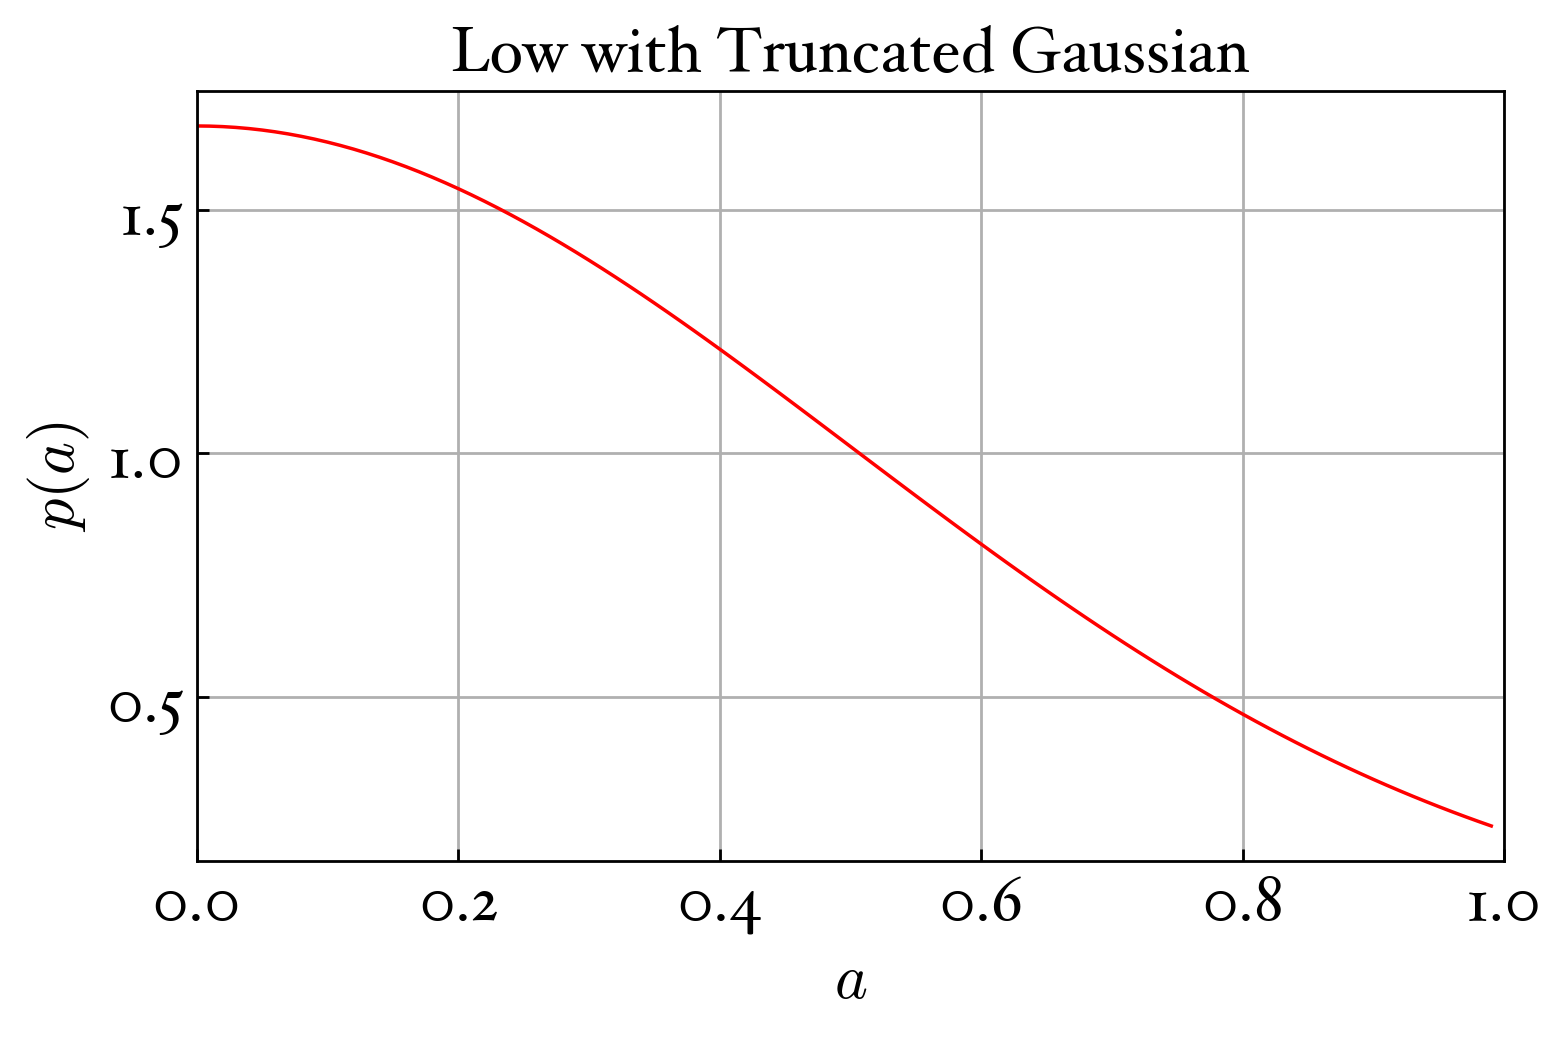

In [8]:
fig, ax = plt.subplots()
chi1s = []
chi2s = []
probs1 = []
probs2 = []
for i in range(0, 100):
# for i in range(-100, 101):
    chi1s.append(i*0.01)
    chi2s.append(i*0.01)
    probs1.append(priors['a_1'].prob(i*0.01))
    probs2.append(priors['a_2'].prob(i*0.01))
    # if (i==-100):
    #     probs1.append(priors['a_1']+1)
    #     probs2.append(priors['a_2']+1)
    # else:
    #     probs1.append(priors['a_1']*0)
    #     probs2.append(priors['a_2']*0)
ax.plot(chi1s, probs1, color='#ff0000')
ax.set_title('Low with Truncated Gaussian')
ax.set_xlabel(r'$a$')
ax.set_ylabel(r'$p(a)$')
ax.set_xlim(0,1)
# ax.set_xlabel(r'cos($\theta$)')
# ax.set_ylabel(r'$p$(cos($\theta$))')